# Train, test loading

In [1]:
print('loading train...', flush=True, end='')

# x를 loading해서 (batch_size, step, channel)
input_path = '../DL_model/dataset/preprocess2/input3-2/'
x_train = np.load(input_path+'x_train.npz', allow_pickle=True)['arr_0']
x_test = np.load(input_path+'x_test.npz', allow_pickle=True)['arr_0']
x_val = np.load(input_path+'x_val.npz', allow_pickle=True)['arr_0']
y_train = np.load(input_path+'y_train.npz')['arr_0']
y_test = np.load(input_path+'y_test.npz')['arr_0']
y_val = np.load(input_path+'y_val.npz')['arr_0']
print('done', flush=True)


print('x_train shape:', x_train.shape)
print('x_test.shape:', x_test.shape)
print('x_val.shape:', x_val.shape)


# random shuffling - train set
ids = np.arange(x_train.shape[0])
np.random.shuffle(ids)

x_train = x_train[ids]
y_train = y_train[ids]


# random shuffling - vall set
ids = np.arange(x_val.shape[0])
np.random.shuffle(ids)

x_val = x_val[ids]
y_val = y_val[ids]


# random shuffling
ids = np.arange(x_test.shape[0])
np.random.shuffle(ids)

x_test = x_test[ids]
y_test = y_test[ids]
                          
                          
# binary classification
y_train_bin = y_train >= 4
y_test_bin = y_test >= 4
y_val_bin = y_val >= 4

loading train...done
x_train shape: (116619, 5000, 2)
x_test.shape: (13749, 5000, 2)
x_val.shape: (13128, 5000, 2)


In [8]:
print('y_train의 평균: {:.4f}, y_test의 평균: {:.4f}'.format(np.mean(y_train_bin), np.mean(y_test_bin)))
print('y_val의 평균: {:.4f}'.format(np.mean(y_val_bin)))

y_train의 평균: 0.6065, y_test의 평균: 0.5790
y_val의 평균: 0.6111


In [2]:
import tensorflow as tf

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

4 Physical GPUs, 4 Logical GPUs


# Model

In [3]:
from keras.models import Sequential
from keras.models import Model, load_model
from keras.optimizers import Adam as Adam
from keras.layers import Dense, Conv1D, MaxPooling1D, GlobalMaxPool1D, BatchNormalization, Dropout, Activation
from keras.layers import GlobalAveragePooling1D, Flatten, SeparableConv1D, AveragePooling1D, Input, concatenate, add, LSTM, Average
from keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.metrics import auc, classification_report, confusion_matrix, accuracy_score, roc_curve, roc_auc_score, f1_score, precision_recall_curve
import tensorflow as tf
import os, pickle
from keras import backend as K


def inception(inp, nfilters=32):
    # 각각은 길이가 줄어들지 않는다

    # 1 conv
    c1 = Conv1D(filters=nfilters, kernel_size=1, kernel_initializer='glorot_uniform', padding='same', activation='relu')(inp)

    # 3 reduce
    c2 = Conv1D(filters=nfilters  , kernel_size=1, kernel_initializer='glorot_uniform', padding='same', activation='relu')(inp)
    # 3 conv
    c2 = Conv1D(filters=nfilters, kernel_size=3, kernel_initializer='glorot_uniform', padding='same', activation='relu')(c2)

    # 5 reduce
    c3 = Conv1D(filters=nfilters, kernel_size=1, kernel_initializer='glorot_uniform', padding='same', activation='relu')(inp)
    # 5 conv
    c3 = Conv1D(filters=nfilters, kernel_size=5, kernel_initializer='glorot_uniform', padding='same', activation='relu')(c3)

    # pooling
    m1 = MaxPooling1D(pool_size=3, strides=1, padding='same')(inp)
    # pooling proj
    m1 = Conv1D(filters=nfilters, kernel_size=1, kernel_initializer='glorot_uniform', padding='same', activation='relu')(m1)

    return concatenate([c1, c2, c3, m1], axis=-1)


## Training

### Inception with depth

In [3]:
from keras.models import Sequential
from keras.models import Model, load_model
from keras.optimizers import Adam as Adam
from keras.layers import Dense, Conv1D, MaxPooling1D, GlobalMaxPool1D, BatchNormalization, Dropout, Activation
from keras.layers import GlobalAveragePooling1D, Flatten, SeparableConv1D, AveragePooling1D, Input, concatenate, add, LSTM, Average
from keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.metrics import auc, classification_report, confusion_matrix, accuracy_score, roc_curve, roc_auc_score, f1_score, precision_recall_curve
import tensorflow as tf
import os, pickle
from keras import backend as K


# learning related hyperparamters
BATCH_SIZE = 512
learning_rate = 0.002


# inception paramters
ngpu = 1
nfilters=16
nlayer=2
conv1 = 64
dense = 0
dropout1 = 0.2
dropout2 = 0
kernel1 = 9
kernel2 = 7


# 출력 폴더를 생성
model_name = 'model(NRS4)_bin_batch{}_conv{}_k{}_nfilter{}_k{}_nlayer{}_drop{}_dense{}_drop{}'.format(BATCH_SIZE, conv1,kernel1,nfilters,kernel2,nlayer,dropout1,dense,dropout2)

save_path = "output/input3-2_PPG+ECG/Inception_"+model_name
if not os.path.exists(save_path):
    os.mkdir(save_path)
weight_path = save_path + "/weights.hdf5"



# GPU 설정
strategy = tf.distribute.MirroredStrategy(devices=["/gpu:0", "/gpu:1"])
with strategy.scope():
    
    #inp_fnn = Input(shape=(x_train[0].shape[1],))
    inp_cnn = Input(shape=(x_train.shape[1], x_train.shape[2]))

    #out_fnn = inp_fnn
    #out_fnn = Dense(256,  activation='relu')(out_fnn)

    out_cnn = inp_cnn
    out_cnn = Conv1D(filters=conv1, kernel_size=9, padding='same', activation='relu')(out_cnn)
    #out_cnn = Conv1D(filters=conv1, kernel_size=kernel_size, padding='same', activation='relu')(out_cnn)
    out_cnn = MaxPooling1D(pool_size=3, strides=2)(out_cnn)
    out_cnn = BatchNormalization()(out_cnn)

    out_cnn = Conv1D(filters=nfilters*4, kernel_size=7, padding='same', activation='relu')(out_cnn)
    out_cnn = MaxPooling1D(pool_size=3, strides=2)(out_cnn)
    out_cnn = BatchNormalization()(out_cnn)
    
    for ilayer in range(nlayer):
        #inp_blk = out_cnn
        out_cnn = inception(out_cnn, nfilters=nfilters)
        #out_cnn = Conv1D(filters=64, kernel_size=1, padding='same')(out_cnn)
        #out_cnn = add([out_cnn, inp_blk])
        #out_cnn = AveragePooling1D(pool_size=2)(out_cnn)
    out_cnn = GlobalAveragePooling1D()(out_cnn)
    out_cnn = Dropout(dropout1)(out_cnn)
    #out = concatenate([out_cnn, out_fnn])
    out = out_cnn
    #out = Dense(256,  activation='relu')(out)
    #out = Dense(dense,  activation='tanh')(out)
    out = Dropout(dropout2)(out)
    out = Dense(1, activation='sigmoid')(out)

    model = Model(inputs=[inp_cnn], outputs=[out])
    
    
    # model 학습 설정
    model.compile(loss='binary_crossentropy', optimizer=Adam(lr=learning_rate), metrics=["acc", tf.keras.metrics.AUC()])
    hist = model.fit(x_train, y_train_bin, validation_split=0.1, epochs=100, batch_size=BATCH_SIZE, #class_weight={0:2, 1:1}, 
                            callbacks=[ModelCheckpoint(monitor='val_loss', filepath=weight_path, verbose=1, save_best_only=True),
                                        EarlyStopping(monitor='val_loss', patience=5, verbose=0, mode='auto')])

    #tf.keras.backend.clear_session()

model.load_weights(weight_path)
    
# 모델의 아키텍처 및 구조 저장
open(save_path + "/model.json", "wt").write(model.to_json())

# 전체 test 샘플을 한번에 예측
y_pred = model.predict(x_test).flatten()

# 결과를 저장
#np.savetxt(save_path+'/pred_y.txt', y_pred)


# 모델의 history log 저장 - binary classification
for key in hist.history.keys():
    if 'auc' in key and not 'val' in key:
        auc_key = key
#pickle.dump((hist.history['loss'], hist.history['val_loss'], hist.history['accuracy'], hist.history['val_accuracy'], hist.history[auc], hist.history['val_'+auc]), open(save_path+'/history', 'wb'))

# 모델의 history log 저장 - regression
pickle.dump((hist.history['loss'], hist.history['val_loss'], hist.history['acc'], hist.history['val_acc'], hist.history[auc_key], hist.history['val_'+auc_key]), open(save_path+'/history', 'wb'))


INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensor

UnknownError: 3 root error(s) found.
  (0) Unknown:  Failed to get convolution algorithm. This is probably because cuDNN failed to initialize, so try looking to see if a warning log message was printed above.
	 [[node functional_1/conv1d/conv1d (defined at /lib/python3.6/threading.py:916) ]]
	 [[div_no_nan/ReadVariableOp_2/_166]]
  (1) Unknown:  Failed to get convolution algorithm. This is probably because cuDNN failed to initialize, so try looking to see if a warning log message was printed above.
	 [[node functional_1/conv1d/conv1d (defined at /lib/python3.6/threading.py:916) ]]
  (2) Unknown:  Failed to get convolution algorithm. This is probably because cuDNN failed to initialize, so try looking to see if a warning log message was printed above.
	 [[node functional_1/conv1d/conv1d (defined at /lib/python3.6/threading.py:916) ]]
	 [[assert_less_equal/Assert/AssertGuard/branch_executed/_207/_179]]
0 successful operations.
0 derived errors ignored. [Op:__inference_train_function_8187]

Function call stack:
train_function -> train_function -> train_function


### Simple Inception

In [16]:
from keras.models import Sequential
from keras.models import Model, load_model
from keras.optimizers import Adam as Adam
from keras.layers import Dense, Conv1D, MaxPooling1D, GlobalMaxPool1D, BatchNormalization, Dropout, Activation
from keras.layers import GlobalAveragePooling1D, Flatten, SeparableConv1D, AveragePooling1D, Input, concatenate, add, LSTM, Average
from keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.metrics import auc, classification_report, confusion_matrix, accuracy_score, roc_curve, roc_auc_score, f1_score, precision_recall_curve
import tensorflow as tf
import os, pickle
from keras import backend as K


# learning related hyperparamters
BATCH_SIZE = 512
learning_rate = 0.002


# inception paramters
ngpu = 1
nfilters=32
nlayer=1
conv1 = 64
dense = 8
dropout1 = 0.2
dropout2 = 0.2


# initializer & regularizer
#k_init = he_normal(seed=None)
#k_init = None
b_init = None
k_l2 = 0
#k_reg = regularizers.l2(l2=k_l2)
k_reg = None
b_reg = None




# 출력 폴더를 생성
model_name = 'model(NRS4)_bin_batch{}_nfilter{}_nlayer{}_drop{}_dense{}_drop{}'.format(BATCH_SIZE,nfilters,nlayer,dropout1,dense,dropout2)

save_path = "output/input3-2_PPG+ECG/Inception_"+model_name
if not os.path.exists(save_path):
    os.mkdir(save_path)
weight_path = save_path + "/weights.hdf5"



# GPU 설정
strategy = tf.distribute.MirroredStrategy(devices=["/gpu:2", "/gpu:3"])
with strategy.scope():
    
    #inp_fnn = Input(shape=(x_train[0].shape[1],))
    inp_cnn = Input(shape=(x_train.shape[1], x_train.shape[2]))
    out_cnn = inp_cnn
    
    for ilayer in range(nlayer):
        #inp_blk = out_cnn
        out_cnn = inception(out_cnn, nfilters=nfilters)
        #out_cnn = Conv1D(filters=64, kernel_size=1, padding='same')(out_cnn)
        #out_cnn = add([out_cnn, inp_blk])
        #out_cnn = AveragePooling1D(pool_size=2)(out_cnn)
    out_cnn = GlobalAveragePooling1D()(out_cnn)
    out_cnn = Dropout(dropout1)(out_cnn)
    #out = concatenate([out_cnn, out_fnn])
    out = out_cnn
    #out = Dense(256,  activation='relu')(out)
    #out = Dense(dense,  activation='tanh')(out)
    #out = Dropout(dropout2)(out)
    out = Dense(1, activation='sigmoid', kernel_initializer = k_init)(out)

    model = Model(inputs=[inp_cnn], outputs=[out])
    
    
    # model 학습 설정
    model.compile(loss='binary_crossentropy', optimizer=Adam(lr=learning_rate), metrics=["acc", tf.keras.metrics.AUC()])
    hist = model.fit(x_train, y_train_bin, validation_data=(x_val, y_val_bin), epochs=100, batch_size=BATCH_SIZE, #class_weight={0:2, 1:1}, 
                            callbacks=[ModelCheckpoint(monitor='val_loss', filepath=weight_path, verbose=1, save_best_only=True),
                                        EarlyStopping(monitor='val_loss', patience=5, verbose=0, mode='auto')])

    #tf.keras.backend.clear_session()

model.load_weights(weight_path)
    
# 모델의 아키텍처 및 구조 저장
open(save_path + "/model.json", "wt").write(model.to_json())

# 전체 test 샘플을 한번에 예측
y_pred = model.predict(x_test).flatten()

# 결과를 저장
#np.savetxt(save_path+'/pred_y.txt', y_pred)


# 모델의 history log 저장 - binary classification
for key in hist.history.keys():
    if 'auc' in key and not 'val' in key:
        auc_key = key
#pickle.dump((hist.history['loss'], hist.history['val_loss'], hist.history['accuracy'], hist.history['val_accuracy'], hist.history[auc], hist.history['val_'+auc]), open(save_path+'/history', 'wb'))

# 모델의 history log 저장 - regression
pickle.dump((hist.history['loss'], hist.history['val_loss'], hist.history['acc'], hist.history['val_acc'], hist.history[auc_key], hist.history['val_'+auc_key]), open(save_path+'/history', 'wb'))


INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:2', '/job:localhost/replica:0/task:0/device:GPU:3')
Epoch 1/100
INFO:tensorflow:batch_all_reduce: 14 all-reduces with algorithm = nccl, num_packs = 1
INFO:tensorflow:batch_all_reduce: 14 all-reduces with algorithm = nccl, num_packs = 1
228/228 [==============================] - ETA: 0s - loss: 0.6847 - acc: 0.5953 - auc_1: 0.5665
Epoch 00001: val_loss improved from inf to 0.61733, saving model to output/input3-2_PPG+ECG/Inception_model(NRS4)_bin_batch512_nfilter32_nlayer1_drop0.2_dense8_drop0.2/weights.hdf5
228/228 [==============================] - 31s 134ms/step - loss: 0.6847 - acc: 0.5953 - auc_1: 0.5665 - val_loss: 0.6173 - val_acc: 0.6751 - val_auc_1: 0.6998
Epoch 2/100
227/228 [============================>.] - ETA: 0s - loss: 0.5873 - acc: 0.7174 - auc_1: 0.7286
Epoch 00002: val_loss improved from 0.61733 to 0.55339, saving model to output/input3-2_PPG+ECG/Inception_model(NRS4)_bin_

Epoch 19/100
227/228 [============================>.] - ETA: 0s - loss: 0.4924 - acc: 0.7882 - auc_1: 0.7832
Epoch 00019: val_loss did not improve from 0.48104
228/228 [==============================] - 28s 121ms/step - loss: 0.4925 - acc: 0.7881 - auc_1: 0.7833 - val_loss: 0.4828 - val_acc: 0.8001 - val_auc_1: 0.7790
Epoch 20/100
227/228 [============================>.] - ETA: 0s - loss: 0.4908 - acc: 0.7897 - auc_1: 0.7835
Epoch 00020: val_loss improved from 0.48104 to 0.48068, saving model to output/input3-2_PPG+ECG/Inception_model(NRS4)_bin_batch512_nfilter32_nlayer1_drop0.2_dense8_drop0.2/weights.hdf5
228/228 [==============================] - 28s 121ms/step - loss: 0.4907 - acc: 0.7898 - auc_1: 0.7834 - val_loss: 0.4807 - val_acc: 0.8038 - val_auc_1: 0.7822
Epoch 21/100
227/228 [============================>.] - ETA: 0s - loss: 0.4888 - acc: 0.7896 - auc_1: 0.7851
Epoch 00021: val_loss did not improve from 0.48068
228/228 [==============================] - 28s 121ms/step - loss: 

Epoch 41/100
227/228 [============================>.] - ETA: 0s - loss: 0.4751 - acc: 0.7953 - auc_1: 0.7935
Epoch 00041: val_loss improved from 0.46792 to 0.46753, saving model to output/input3-2_PPG+ECG/Inception_model(NRS4)_bin_batch512_nfilter32_nlayer1_drop0.2_dense8_drop0.2/weights.hdf5
228/228 [==============================] - 27s 120ms/step - loss: 0.4752 - acc: 0.7953 - auc_1: 0.7935 - val_loss: 0.4675 - val_acc: 0.8081 - val_auc_1: 0.7901
Epoch 42/100
227/228 [============================>.] - ETA: 0s - loss: 0.4744 - acc: 0.7960 - auc_1: 0.7944
Epoch 00042: val_loss improved from 0.46753 to 0.46647, saving model to output/input3-2_PPG+ECG/Inception_model(NRS4)_bin_batch512_nfilter32_nlayer1_drop0.2_dense8_drop0.2/weights.hdf5
228/228 [==============================] - 27s 120ms/step - loss: 0.4744 - acc: 0.7960 - auc_1: 0.7944 - val_loss: 0.4665 - val_acc: 0.8055 - val_auc_1: 0.7899
Epoch 43/100
227/228 [============================>.] - ETA: 0s - loss: 0.4738 - acc: 0.7959

In [5]:
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 5000, 2)]    0                                            
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 5000, 16)     48          input_1[0][0]                    
__________________________________________________________________________________________________
conv1d_3 (Conv1D)               (None, 5000, 16)     48          input_1[0][0]                    
__________________________________________________________________________________________________
max_pooling1d (MaxPooling1D)    (None, 5000, 2)      0           input_1[0][0]                    
_______________________________________________________________________________________

## Model evaluation

test set accuracy:0.78
test set auroc: 0.7635833772420577


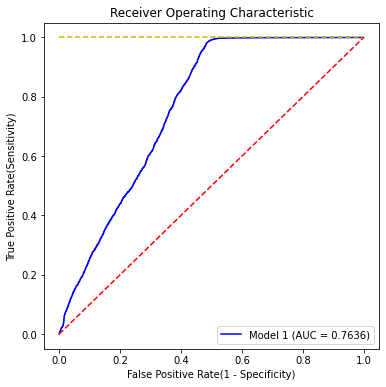

In [17]:
from sklearn.metrics import roc_curve, auc, r2_score
from numpy import interp
from keras import losses, metrics
import keras.backend as K
import matplotlib.pyplot as plt

### Classification
# Model Accuracy of test set
model_y = y_pred>=0.5
acc_val = np.mean(model_y==y_test_bin)
print('test set accuracy:{:.2f}'.format(acc_val))


# Model AUROC
false_positive_rate, true_positive_rate, threshold = roc_curve(y_test_bin, y_pred)
roc_auc = auc(false_positive_rate, true_positive_rate)
print('test set auroc:', roc_auc)

# Model R_square
#print('test set R2:', r2_score(y_test, y_pred*9))


# Adding evaluation results to file name
# classification
#os.rename(save_path, save_path+'_auc{:.4f}_acc{:.4f}'.format(roc_auc,np.mean(model_y==y_test_bin)))

# regression
os.rename(save_path, 'output/input3-2_PPG+ECG/auc{:.4f}_Inception_{}acc{:.2f}'.format(roc_auc,model_name,acc_val))


# plotting roc
plt.figure(figsize=(6,6))
plt.title('Receiver Operating Characteristic')
plt.xlabel("False Positive Rate(1 - Specificity)")
plt.ylabel('True Positive Rate(Sensitivity)')

plt.plot(false_positive_rate, true_positive_rate, 'b', label='Model 1 (AUC = %0.4f)'% roc_auc)
plt.plot([0,1],[1,1],'y--')
plt.plot([0,1],[0,1],'r--')

plt.legend(loc='lower right')
plt.show()

## Model History Plot

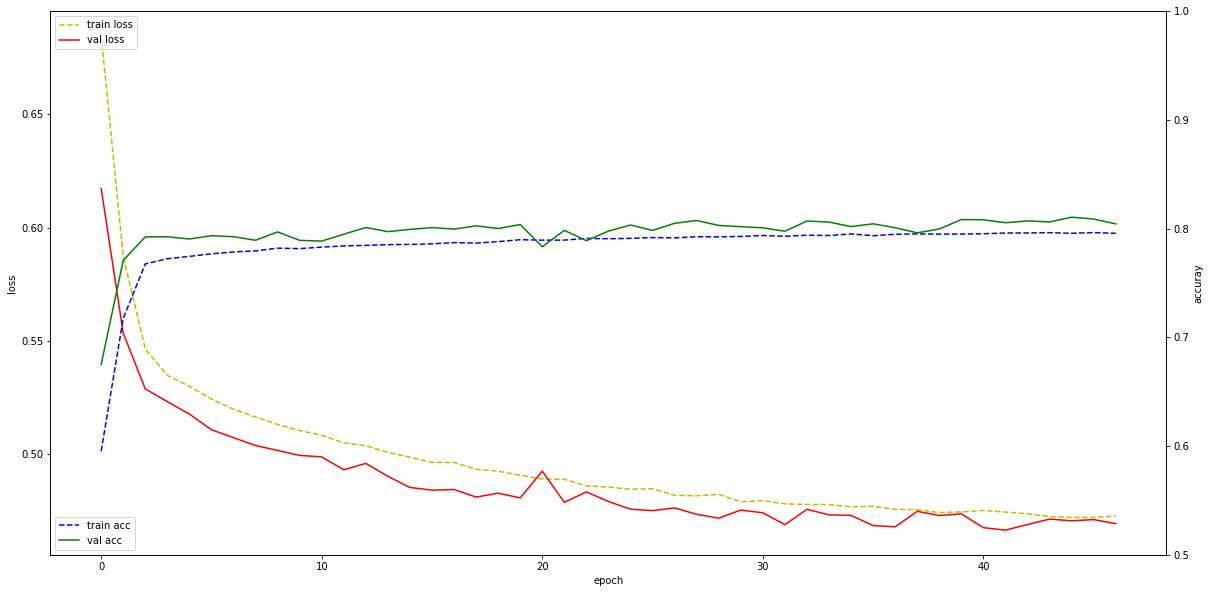

In [18]:
# model auroc 0.719짜리
%matplotlib inline
import matplotlib.pyplot as plt

fig, loss_ax = plt.subplots(figsize=(20,10))

#x-axis는 공유하지만 y-axis는 공유x
acc_ax = loss_ax.twinx()

loss_ax.plot(hist.history['loss'], 'y', linestyle='dashed', label='train loss')
loss_ax.plot(hist.history['val_loss'], 'r', label='val loss')

#acc_ax.plot(hist.history['mean_absolute_error'], 'b', linestyle='dashed',label='train mae')
#acc_ax.plot(hist.history['val_mean_absolute_error'], 'g', label='val mae')
acc_ax.plot(hist.history['acc'], 'b', linestyle='dashed',label='train acc')
acc_ax.plot(hist.history['val_acc'], 'g', label='val acc')

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax.set_ylim(0.5,1.0)
acc_ax.set_ylabel('accuray')

loss_ax.legend(loc='upper left')
acc_ax.legend(loc='lower left')

plt.show()

## 검증

In [11]:
test_result = model.evaluate(x=x_test, y=y_test_bin, batch_size=512, verbose=1, sample_weight=None, steps=None, callbacks=None)


27/27 [==============================] - 1s 30ms/step - loss: 0.5131 - acc: 0.7736 - auc: 0.7675


In [12]:
val_result = model.evaluate(x=x_val, y=y_val_bin, batch_size=BATCH_SIZE, verbose=1, sample_weight=None, steps=None, callbacks=None)


26/26 [==============================] - 1s 29ms/step - loss: 0.4640 - acc: 0.7982 - auc: 0.7986


In [13]:
train_result = model.evaluate(x=x_train, y=y_train_bin, batch_size=BATCH_SIZE, verbose=1, sample_weight=None, steps=None, callbacks=None)


228/228 [==============================] - 7s 32ms/step - loss: 0.3732 - acc: 0.8316 - auc: 0.8806


In [31]:
y_val_pred = model.predict(x_train[-13130:]).flatten()
y_val_pred = y_val_pred>=0.5

np.mean(y_train_bin[-13130:]==np.array(y_val_pred))

0.970982482863671

In [32]:
print('y_train의 평균: {:.4f}, y_test의 평균: {:.4f}'.format(np.mean(y_train_bin), np.mean(y_test_bin)))
print('y_val의 평균: {:.4f}'.format(np.mean(y_train_bin[-13130:])))

y_train의 평균: 0.4847, y_test의 평균: 0.4669
y_val의 평균: 0.4855


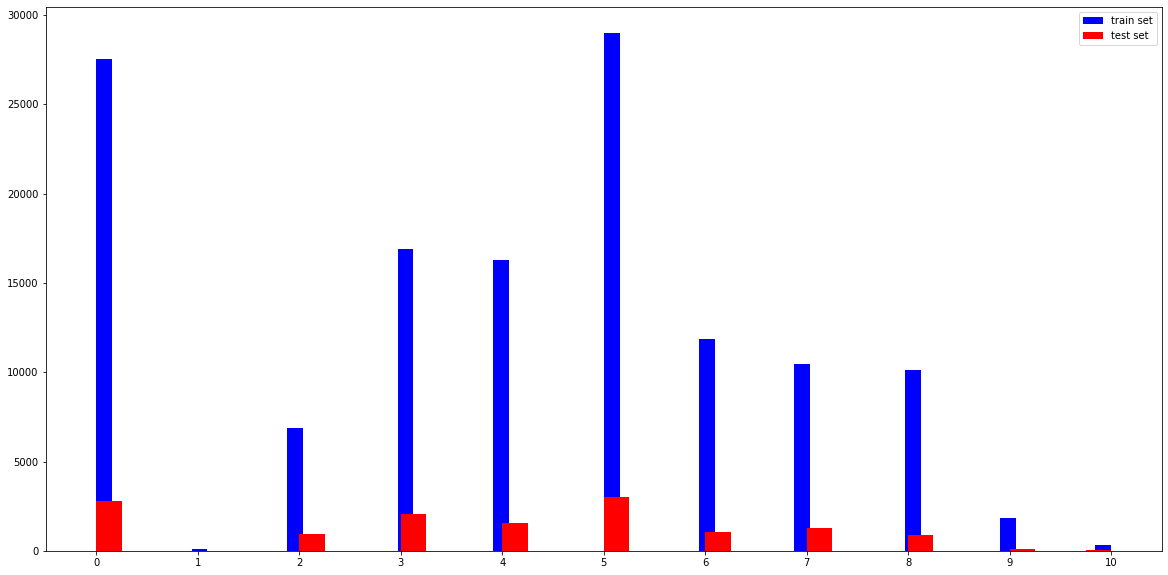

In [39]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.hist(y_train, bins='auto', color='b', label='train set')
plt.hist(y_test, bins='auto', color='r', label='test set')
plt.xticks(np.arange(0,11))
plt.legend(loc='best')

plt.figure(figsize=(20,10))
plt.hist(y_train, bins='auto', color='b', label='train set')
plt.hist(y_test, bins='auto', color='r', label='test set')
plt.xticks(np.arange(0,11))
plt.legend(loc='best')

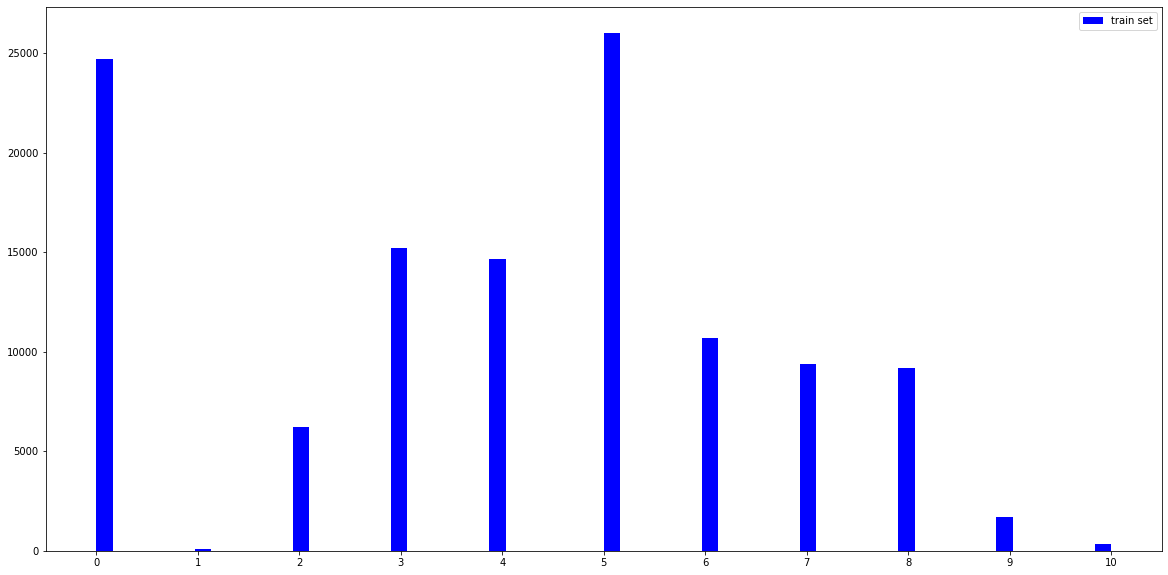

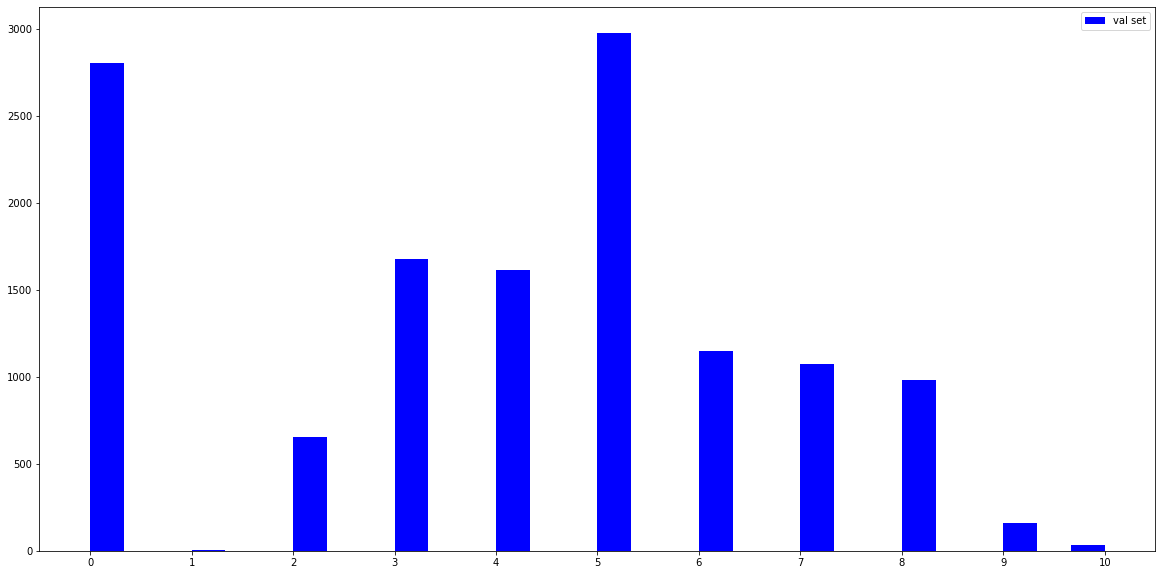

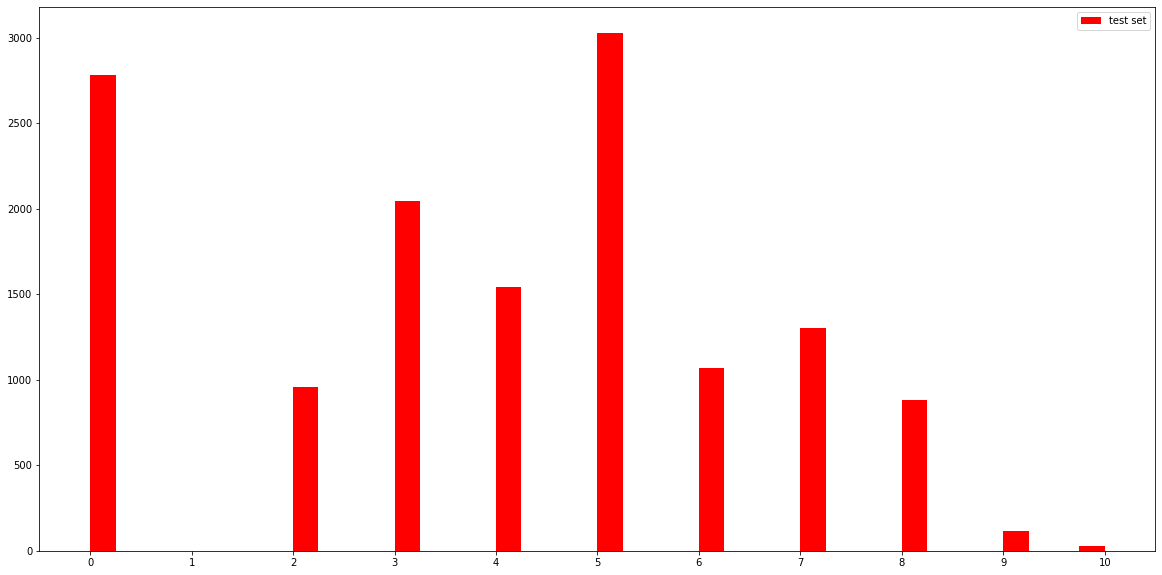

In [41]:
plt.figure(figsize=(20,10))
plt.hist(y_train[:-13130], bins='auto', color='b', label='train set')
plt.xticks(np.arange(0,11))
plt.legend(loc='best')

plt.figure(figsize=(20,10))
plt.hist(y_train[-13130:], bins='auto', color='b', label='val set')
plt.xticks(np.arange(0,11))
plt.legend(loc='best')



plt.figure(figsize=(20,10))
plt.hist(y_test, bins='auto', color='r', label='test set')
plt.xticks(np.arange(0,11))
plt.legend(loc='best')

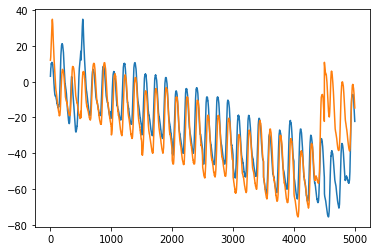

In [51]:
plt.plot(x_test[0,:,0])
plt.plot(x_test[1,:,0])
plt.show()

In [61]:
input_path = 'dataset/preprocess2/input3-2/'

# loading pacu
print('loading pacu data...', flush=True, end='')
x_train_pacu = np.load(input_path+'x_train_pacu.npz', allow_pickle=True)['arr_0']

loading pacu data...

In [60]:
np.mean(x_train_pacu[2,:,0])

-3.646425

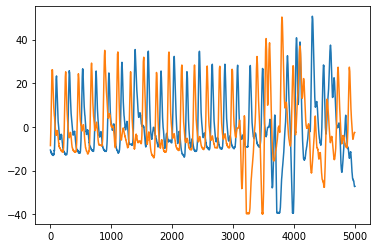

In [65]:
plt.plot(x_train_pacu[0,0,:])
plt.plot(x_train_pacu[1,0,:])
plt.show()